In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import ureg, quantity_to_activity, activity_to_quantity

from baby_run_5 import *

In [2]:
k_wall_factors = [0.2, 0.5, 1, 2, 3, 4]
k_top_factors = [1, 1, 1, 1, 0.9, 0.72]
neutron_rate_factors = [0.8, 0.88, 1, 1.2, 1.5, 2]

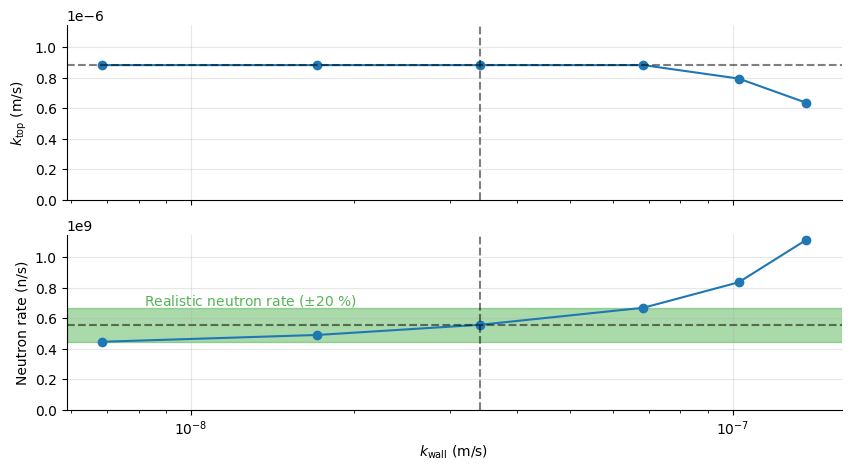

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

plt.sca(axs[0])
plt.plot((baby_model.k_wall*np.array(k_wall_factors)), baby_model.k_top*np.array(k_top_factors), '-o')
plt.axvline(baby_model.k_wall, color='k', linestyle='--', alpha=0.5)
plt.axhline(baby_model.k_top, color='k', linestyle='--', alpha=0.5)

plt.ylim(0, baby_model.k_top * 1.3)
plt.xscale("log")
plt.ylabel("$k_\mathrm{top}$ (m/s)")

plt.sca(axs[1])
plt.plot((baby_model.k_wall*np.array(k_wall_factors)), baby_model.neutron_rate*np.array(neutron_rate_factors) , '-o')
plt.axvline(baby_model.k_wall, color='k', linestyle='--', alpha=0.5)
plt.axhline(baby_model.neutron_rate, color='k', linestyle='--', alpha=0.5)

plt.axhspan(baby_model.neutron_rate * 0.8, baby_model.neutron_rate * 1.2, color='tab:green', alpha=0.4)
plt.annotate("Realistic neutron rate ($\pm $20 %)", (0.1, 0.6), xycoords='axes fraction', color='tab:green', alpha=0.8)

plt.xlabel("$k_\mathrm{wall}$ (m/s)")
plt.ylabel("Neutron rate (n/s)")
plt.ylim(bottom=0)

# remove top and right axes for both subplots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3)


In [4]:
models = []
for k_wall_fac, k_top_fac, neutron_rate_fac in zip(k_wall_factors, k_top_factors, neutron_rate_factors):
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
    )

    new_baby_model.k_top = baby_model.k_top * k_top_fac
    new_baby_model.k_wall = baby_model.k_wall * k_wall_fac

    new_baby_model.number_days = baby_model.number_days
    new_baby_model.exposure_time = baby_model.exposure_time
    new_baby_model.neutron_rate = baby_model.neutron_rate * neutron_rate_fac
    new_baby_model.dt = baby_model.dt
    new_baby_model.run(7 * ureg.day)
    models.append(new_baby_model)

/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
# baby_model.k_wall *= 3
# baby_model.k_top *= 0.9
# baby_model.neutron_rate *= 1.5


In [6]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml


def plot_model(
    model,
    top=True,
    walls=True,
    detection_limit=0.4 * ureg.Bq,
    irradiation=True,
    replace_vials=True,
    title=True,
    subtitle=True,
    linelabel=True,
):
    plt.gca().xaxis.set_units(ureg.day)
    plt.gca().yaxis.set_units(ureg.Bq)

    if title:
        plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
    if subtitle:
        subtitle_text = [
            f"TBR = {model.TBR.to(ureg.dimensionless):.2e~P}, salt volume {model.volume.to(ureg.ml):.0f~P}, neutron rate: {model.neutron_rate:.2e~P}, irradiation time: {model.exposure_time}",
            f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}",
        ]
        plt.gcf().text(0.08, 0.9, s="\n".join(subtitle_text), fontsize=6.5)

    if top:
        integrated_top = quantity_to_activity(model.integrated_release_top()).to(
            ureg.Bq
        )
        sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_top, times = replace_water(
                sample_activity_top, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_top,
            color="#023047",
            label="Top",
        )
    if walls:
        integrated_wall = quantity_to_activity(model.integrated_release_wall()).to(
            ureg.Bq
        )
        sample_activity_wall = integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_wall, times = replace_water(
                sample_activity_wall, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_wall,
            color="tab:green",
            label="Walls",
        )

    if detection_limit:
        plt.axhline(y=detection_limit, color="tab:grey", linestyle="dashed")

    if irradiation:
        if irradiation is True:
            for day in range(model.number_days.to(ureg.day).magnitude):
                plt.axvspan(
                    0 * ureg.h + day * ureg.day,
                    model.exposure_time + day * ureg.day,
                    facecolor="#EF5B5B",
                    alpha=0.5,
                )
        else:
            for irr in irradiation:
                plt.axvspan(
                    irr[0].to(ureg.day),
                    irr[1].to(ureg.day),
                    facecolor="#EF5B5B",
                    alpha=0.5,
                )

    plt.xlim(left=0 * ureg.day)
    plt.ylim(bottom=0)
    # plt.yscale("log")
    if linelabel:
        labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.grid(alpha=0.5)

/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


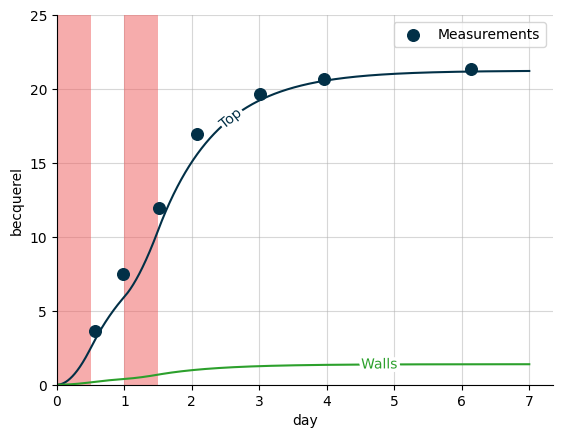

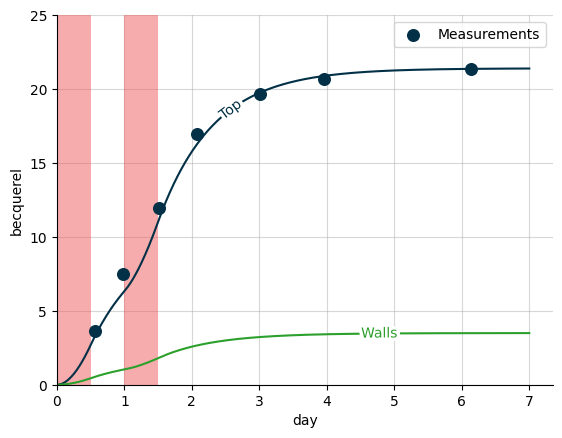

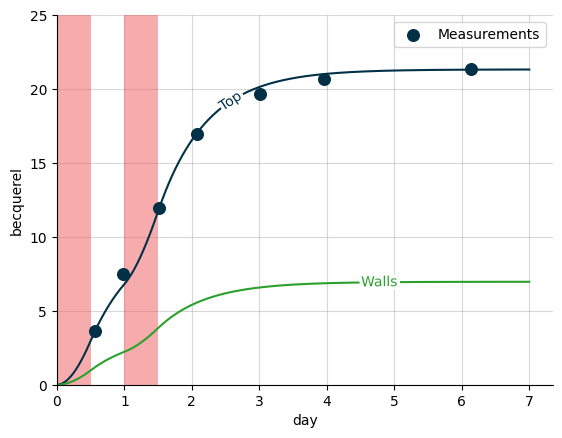

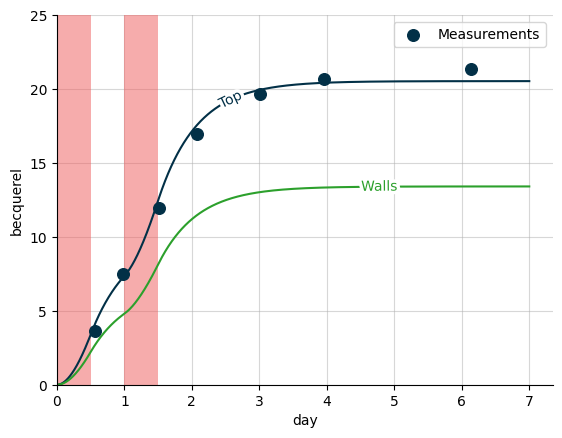

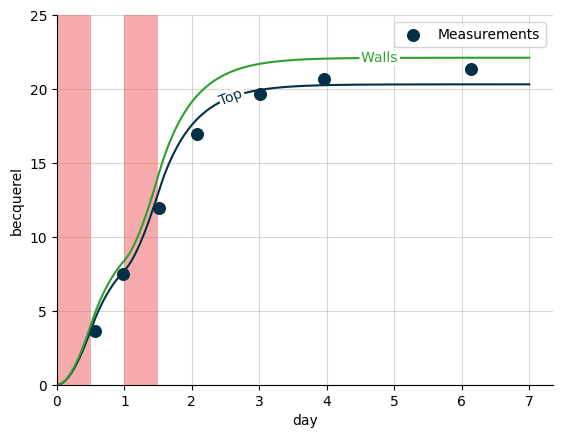

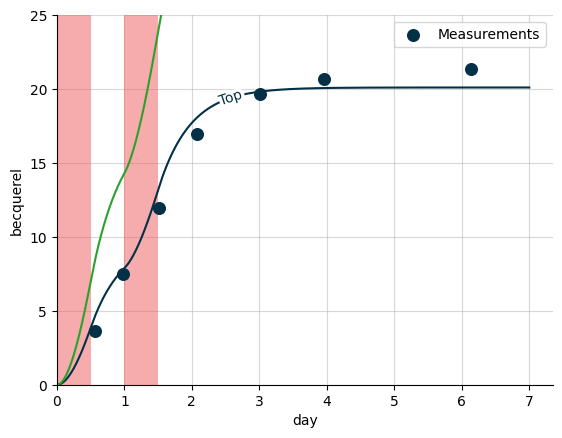

In [7]:
sample_1 = vial_511 + vial_512 + vial_513 + vial_514
sample_2 = vial_521 + vial_522 + vial_523 + vial_524
sample_3 = vial_531 + vial_532 + vial_533 + vial_534
sample_4 = vial_541 + vial_542 + vial_543 + vial_544
sample_5 = vial_551 + vial_552 + vial_553 + vial_554
sample_6 = vial_561 + vial_562 + vial_563 + vial_564
sample_7 = vial_571 + vial_572 + vial_573 + vial_574

cumulative_1 = sample_1
cumulative_2 = sample_1 + sample_2
cumulative_3 = sample_1 + sample_2 + sample_3
cumulative_4 = sample_1 + sample_2 + sample_3 + sample_4
cumulative_5 = sample_1 + sample_2 + sample_3 + sample_4 + sample_5
cumulative_6 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6
)
cumulative_7 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6 + sample_7
)
cumulative_values = [cumulative_1, cumulative_2, cumulative_3, cumulative_4, cumulative_5, cumulative_6, cumulative_7]

plt.figure()
for model in models:
    plot_model(
        model=model,
        replace_vials=False,
        title=False,
        subtitle=False,
        walls=True,
        detection_limit=None,
        linelabel=True,
    )

    s = plt.scatter(
        replacement_times,
        cumulative_values,
        s=70,
        label="Measurements",
        color="#023047"
    )
    plt.legend(handles=[s])
    # plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
    plt.gca().set_axisbelow(True)
    plt.ylim(top=25 * ureg.Bq)
    plt.show()


In [8]:
def add_subplot_axes(ax,rect,facecolor='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

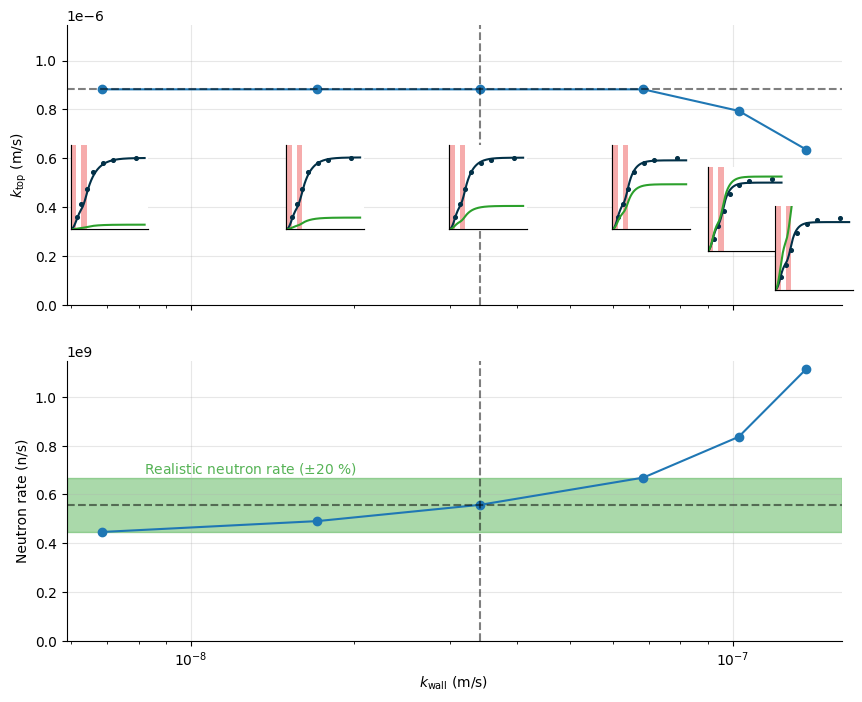

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

plt.sca(axs[0])
plt.plot((baby_model.k_wall*np.array(k_wall_factors)), baby_model.k_top*np.array(k_top_factors), '-o')
plt.axvline(baby_model.k_wall, color='k', linestyle='--', alpha=0.5)
plt.axhline(baby_model.k_top, color='k', linestyle='--', alpha=0.5)

plt.ylim(0, baby_model.k_top * 1.3)
plt.xscale("log")
plt.ylabel("$k_\mathrm{top}$ (m/s)")

plt.sca(axs[1])
plt.plot((baby_model.k_wall*np.array(k_wall_factors)), baby_model.neutron_rate*np.array(neutron_rate_factors) , '-o')
plt.axvline(baby_model.k_wall, color='k', linestyle='--', alpha=0.5)
plt.axhline(baby_model.neutron_rate, color='k', linestyle='--', alpha=0.5)

plt.axhspan(baby_model.neutron_rate * 0.8, baby_model.neutron_rate * 1.2, color='tab:green', alpha=0.4)
plt.annotate("Realistic neutron rate ($\pm $20 %)", (0.1, 0.6), xycoords='axes fraction', color='tab:green', alpha=0.8)

plt.xlabel("$k_\mathrm{wall}$ (m/s)")
plt.ylabel("Neutron rate (n/s)")
plt.ylim(bottom=0)

# remove top and right axes for both subplots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3)

width = 0.1
height = 0.3
xpos = []
for i, model in enumerate(models):
    x0, y0 = axs[0].transLimits.transform((np.log10(model.k_wall.magnitude), model.k_top.magnitude))
    # y0 = 0.3
    offset = 0.5
    ins = axs[0].inset_axes([x0-0.04, y0 - offset, width, height])
    fig.add_axes(ins)
    plt.sca(ins)
    plot_model(
        model=model,
        replace_vials=False,
        title=False,
        subtitle=False,
        walls=True,
        detection_limit=None,
        linelabel=False,
    )

    s = plt.scatter(
        replacement_times,
        cumulative_values,
        s=7,
        label="Measurements",
        color="#023047"
    )
    plt.gca().set_axisbelow(True)
    plt.ylim(top=25 * ureg.Bq)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")
